# ORUCE autoconsommation PV

## Informations générales

- **Contexte de l'étude** : Ce notebook présente un cas d'étude autour de l'autoconsommation photovoltaïque d'une habitation en phase de pré-étude. L'étude se concentre sur un seul bâtiment représentatif équipé de panneaux PV et d'un stockage par batterie. Il a été développé dans le cadre de travaux de thèse pour présenter la méthode [ORUCE](https://hal.archives-ouvertes.fr/hal-03341883) (Open and Reproducible Use Case for Energy).
- **Licence** : [Apache 2.0](https://www.apache.org/licenses/LICENSE-2.0.html)
- Lien mybinder pour une utilisation en ligne [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fomegalpes%2Fomegalpes_examples/HEAD?labpath=%2Fnotebooks%2FPhD_2022_Sacha_Hodencq%2FORUCE_autoconso_PV.ipynb)
- **Référence** : section III.4 de la [thèse de Sacha Hodencq](http://www.theses.fr/s225905).
- **Outil** : [OMEGAlpes](https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes/omegalpes), version 0.4.2, licence Apache 2.0 
- Lien vers d'autres cas d'étude liés :
   - Voir notamment le cas d'étude dont est inspiré ce notebook, plus détaillé : [Open and Reproducible Use Cases in the Energy field for systems design and operation: a dwelling photovoltaic self-consumption example](https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes/omegalpes_examples/-/blob/master/notebooks/article_2021_BS_ORUCE.ipynb)
   - et le notebook lié, développé avec l'outil [NoLOAD](https://gricad-gitlab.univ-grenoble-alpes.fr/design_optimization/noload) : [Energy systems optimisation models for Life Cycle Assessment : a dwelling photovoltaic system study case using NoLOAD](https://gricad-gitlab.univ-grenoble-alpes.fr/design_optimization/noload_benchmarks_open/-/blob/master/examples/pv_battery_coverage_gwp/pv_battery_coverage_gwp.ipynb)
- **Développeur - institution** : Sacha Hodencq (sacha.hodencq@g2elab.grenoble-inp.fr) - G2Elab   
- [Fiche descriptive](#Fiche-descriptive) en fin de notebook

## Table des matières

- [Informations générales](#Informations-générales)
- [Gestion des données](#Gestion-des-données)
- [Présentation de la modélisation énergétique](#Présentation-de-la-modélisation-énergétique)
- [Processus de modélisation énergétique](#Processus-de-modélisation-énergétique)
- [Gestion des résultats](#Gestion-des-résultats)
- [Conclusion](#Conclusion)
- [Fiche cas d'étude](#Fiche-descriptive)

**Import des packages nécessaires**

Un petit [guide de gestion de l'environnement](https://pad.lescommuns.org/ORUCE_fr?view#Travailler-dans-un-environnement-%E2%80%A6) selon votre situation.

***Code à exécuter si vous êtes sur mybinder*** (retirez les "#" devant les lignes de code) :

In [1]:
#################################################################################
# import os
# os.system('pip install -r NB_requirements/ORUCE_autoconso_PV_requirements.txt')
#################################################################################

In [2]:
import pulp

from pulp import LpStatus

import numpy as np
import pandas as pd
from python_scripts.NB_ORUCE_utils import *
from python_scripts.enedis_apis import coefficient_des_profils
from omegalpes.general.optimisation.elements import Objective

## Gestion des données

### Profils d'ensoleillement 
Les profils d'irradiation et de consommation peuvent être adaptés en fonction de la localisation ou des spécificités des consommateurs.
Dans cette étude, nous prenons les profils d'irradiance de Grenoble :

   - DHI : Diffuse Horizontal Irradiation (W/m²)
   - DNI : Direct Normal Irradiation (W/m²)

Ces données d'irradiation proviennent de la [station météo de GreEn-Er](https://g2elab-shiny.g2elab.grenoble-inp.fr/meteo-greener/#dashboard) (bâtiment de l'école G2Elab et ENSE3), stockés sur le serveur MHI (Monitorat et Habitat Intelligent) dans une [base de données influxDB](http://mhi-srv.g2elab.grenoble-inp.fr/API/) sous une licence [Public Domain Dedication and License version v1.0](https://opendatacommons.org/licenses/pddl/1-0/).

Irradiance (basée sur l'[OEMetadata](https://github.com/OpenEnergyPlatform/oemetadata/blob/develop/metadata/latest/metadata_key_description.md)) : 

|#|Key |Parameter |
|---|---|---|
| 1 | name |irradiance_data.csv| 
| 2 | title | Données d'irradiance à Grenoble en 2019| 
| 3 | id | |
| 4 | description | Données d'irradiance à Grenoble comprenant le DHI et DNI |
| 5 | language | |
| 6 | subject |  |
| 7 | keywords | |
| 8 | publicationDate |2020 |
| 9 | context | |
| 10 | spatial |Grenoble, 21 avenue des Martyrs| 
| 11 | temporal | 2019, pas de temps horaire|
| 12 | source |http://mhi-srv.g2elab.grenoble-inp.fr/API/ |
| 13 | licenses | Public Domain Dedication and License version v1.0. |
| 14 | contributors | Delinchant B. and Laranjeira T. |
| 15 | resources |Delinchant B., Wurtz F., Ploix S., Schanen J.-L. and Marechal Y. (2016). "GreEn-ER Living Lab - A Green Building with Energy Aware Occupants". SmartGreen'16, In proceedings of the 5th International Conference on Smart Cities and Green ICT Systems. ISBN 978-989-758-184-7, pages 316-323. DOI: 10.5220/0005795303160323 |

La fonction `extract_csv_from_mhi` peut être utilisée pour récupérer les données du serveur.

In [3]:
extract_csv_from_mhi(start=datetime(year=2019, month=1, day=1),
                         end=datetime(year=2020, month=1, day=1))

File irradiance_data.csv generated


**Si vous exécutez ce script sur mybinder**, vous obtiendrez une *Timeout ou Connection error*, car cette requête ne peut pas être exécutée. Veuillez utiliser un autre service ou une version locale du Jupyter Notebook. **Vous pouvez directement aller à la partie [Gestion des données à partir d'un fichier csv](#Gestion-csv)**, et utiliser les données disponibles sur le serveur gitlab de ce notebook. D'autres requêtes fonctionnant sur mybinder peuvent également être utilisées (fonction get_data, voir la cellule ci-dessous) avec des requêtes http, qui sont autorisées par mybinder. Cependant, ces demandes ne permettent d'accéder aux données du serveur qu'à partir du début de 2021. Si vous n'exécutez pas ce Jupyter Notebook sur mybinder, le serveur de données peut ne pas être accessible.

In [4]:
# USING get_data FUNCTION

# data_url=get_data(url="http://mhi-srv.g2elab.grenoble-inp.fr/django/API/environment")
# # In the obtained data, plot 3 includes irradiance data we are looking for
# data_sun_url = data_url['plot3']
# # Converting into dataframe
# df_sun_url = pd.DataFrame.from_records(data_sun_url['values'])
# # Adding headers. Plot3 includes date in epoch format, Diffuse Horizontal Irradiance and Global Horizontal Irradiance
# df_sun_url.columns = ["date","DHI (W/m²)", "DNI (W/m²)", "GHI (W/m²)"]
# # Converting epoch time format to datatime
# df_sun_url['date'] = pd.to_datetime(df_sun_url['date'],unit='s')
# print(df_sun_url)

Si on revient aux données extraites via la fonction `extract_csv_from_mhi` :

In [5]:
file_name = ('./data/irradiance_data.csv')
raw_irradiance_data = pd.read_csv(file_name, sep=';', decimal=".") 
print("Données brutes : ")
print(raw_irradiance_data)
# Renaming headers
raw_irradiance_data_head = pd.DataFrame({        
        'TIMESTAMP':raw_irradiance_data.iloc[:,0],
        'DHI': raw_irradiance_data['sun_diffus'],
        'DNI': raw_irradiance_data['sun_direct'],        
    }, index=raw_irradiance_data.index)       

# Setting TIMESTAMP index with proper datetime format
raw_irradiance_data_head['TIMESTAMP'] = pd.to_datetime(raw_irradiance_data_head['TIMESTAMP'])
raw_irradiance_data_head.set_index('TIMESTAMP',inplace=True)

# Resampling with mean function to get hourly data
hourly_irradiance_data = raw_irradiance_data_head.resample('H').mean()
print("Données mises en forme : ")
print(hourly_irradiance_data)

Données brutes : 
                              Unnamed: 0  sun_diffus  sun_direct
0              2019-01-01 00:00:00+00:00       0.560         0.0
1              2019-01-01 01:00:00+00:00       0.571         0.0
2              2019-01-01 02:00:00+00:00       0.431         0.0
3              2019-01-01 03:00:00+00:00       0.540         0.0
4              2019-01-01 04:00:00+00:00       0.559         0.0
...                                  ...         ...         ...
163836  2019-12-31 23:50:12.328018+00:00       6.000         0.0
163837  2019-12-31 23:52:06.868004+00:00       6.000         0.0
163838  2019-12-31 23:54:09.249520+00:00       6.000         0.0
163839  2019-12-31 23:56:09.900240+00:00       6.000         0.0
163840  2019-12-31 23:58:08.923883+00:00       6.000         0.0

[163841 rows x 3 columns]
Données mises en forme : 
                                DHI  DNI
TIMESTAMP                               
2019-01-01 00:00:00+00:00  0.560000  0.0
2019-01-01 01:00:00+00:00 

In [6]:
# Finding potential errors - NaN
hourly_irradiance_data[hourly_irradiance_data.isnull().any(axis=1)]

DHI  DNI
TIMESTAMP                          
2019-02-20 11:00:00+00:00  NaN  NaN
2019-02-21 11:00:00+00:00  NaN  NaN

In [7]:
hourly_irradiance_data.loc[hourly_irradiance_data['DHI'] <0]

DHI     DNI
TIMESTAMP                                
2019-02-20 12:00:00+00:00 -9999.0 -9999.0
2019-02-20 13:00:00+00:00 -9999.0 -9999.0

In [8]:
hourly_irradiance_data.loc[hourly_irradiance_data['DNI']<0]

DHI     DNI
TIMESTAMP                                
2019-02-20 12:00:00+00:00 -9999.0 -9999.0
2019-02-20 13:00:00+00:00 -9999.0 -9999.0

Dans la version actuelle, certaines lignes ont la valeur "Not a Number" (NaN), et d'autres sont négatives, en raison d'une transmission de données ou d'une défaillance du capteur. Elles peuvent être corrigées par une interpolation. Dans tous les cas, la base de données incluant les profils d'irradiance a été corrigée localement et incluse dans le fichier csv *irradiance_and_consumption_data* importé dans la section suivante [Gestion des données à partir du fichier csv](#Gestion-csv).

In [9]:
# Replacing negative values by NaN
hourly_irradiance_data.loc[hourly_irradiance_data['DHI']<0]=np.nan
hourly_irradiance_data.loc[hourly_irradiance_data['DNI']<0]=np.nan
# Interpolating
hourly_irradiance=hourly_irradiance_data.interpolate()
print(hourly_irradiance[hourly_irradiance.isnull().any(axis=1)])
print(hourly_irradiance.loc[hourly_irradiance['DHI'] <0])
print(hourly_irradiance.loc[hourly_irradiance['DNI']<0])

Empty DataFrame
Columns: [DHI, DNI]
Index: []
Empty DataFrame
Columns: [DHI, DNI]
Index: []
Empty DataFrame
Columns: [DHI, DNI]
Index: []


### Profils de consommation
Les profils de consommation sont obtenus à partir d'un vecteur temporel de coefficients de consommation électrique provenant d'Enedis : les [profils RES1](https://data.enedis.fr/pages/coefficients-des-profils/) c'est-à-dire des coefficients de profils de consommation typiques pour les logements raccordés en basse tension avec une puissance nominale inférieure à 6 kVA. Ces coefficients de profils de consommation sont partagés avec la [licence ouverte v2.0 (Etalab)](https://www.etalab.gouv.fr/wp-content/uploads/2018/11/open-licence.pdf). Nous considérons une consommation annuelle de 4586 kWh par an et par logement, calculée à partir du nombre de foyers raccordés au système électrique français selon ce [rapport de la Commission de régulation de l'énergie (CRE)](https://www.cre.fr/Documents/Publications/Rapports-thematiques/Etat-des-lieux-des-marches-de-detail-de-l-electricite-et-du-gaz-naturel-en-2017), page 19 (32,4 millions de consommateurs résidentiels raccordés en 2017), et de la consommation finale d'électricité du secteur résidentiel français de [148,6 TWh en 2019](https://opendata.reseaux-energies.fr/explore/dataset/consommation-annuelle-nette-typologie/table/?disjunctive.segment&sort=annee). 

L'accès à ces valeurs peut prendre quelques minutes.

Consommation (basée sur l'[OEMetadata](https://github.com/OpenEnergyPlatform/oemetadata/blob/develop/metadata/latest/metadata_key_description.md)) : 

|#|Key |Parameter |
|---|---|---|
| 1 | name | consumption_data.csv|
| 2 | title |Données RES1 | 
| 3 | id | |
| 4 | description | Données de profil type de consommation résidentielle en France en 2019 |
| 5 | language | |
| 6 | subject |  |
| 7 | keywords | |
| 8 | publicationDate | 2020|
| 9 | context | |
| 10 | spatial |France, échelle résidentielle| 
| 11 | temporal | 2019, pas de temps horaire|
| 12 | source |https://data.enedis.fr/pages/coefficients-des-profils/ |
| 13 | licenses |  licence ouverte v2.0 (Etalab) |
| 14 | contributors | [Enedis](https://data.enedis.fr/pages/accueil) |
| 15 | resources |[Démarche open data Enedis](https://www.enedis.fr/open-data) |

In [10]:
raw_res1 = coefficient_des_profils(starting_date = datetime(year=2018, month=12, day=31), nb_days = 366)
print(raw_res1)

# Removing the two last values that are in 2020:
raw_res1.drop(raw_res1.tail(2).index, inplace = True) 

                     COEFFICIENT_PREPARE  COEFFICIENT_AJUSTE  \
0                                                              
2019-01-01 00:00:00               0.9659            0.942429   
2019-01-01 00:30:00               0.8936            0.870277   
2019-01-01 01:00:00               0.8237            0.802136   
2019-01-01 01:30:00               0.7700            0.749734   
2019-01-01 02:00:00               0.7401            0.720413   
...                                  ...                 ...   
2019-12-31 22:30:00               1.2639            1.276135   
2019-12-31 23:00:00               1.0855            1.098298   
2019-12-31 23:30:00               0.9485            0.961049   
2020-01-01 00:00:00               0.9659            0.979983   
2020-01-01 00:30:00               0.8936            0.909149   

                     COEFFICIENT_DYNAMIQUE  
0                                           
2019-01-01 00:00:00               1.053890  
2019-01-01 00:30:00             

Les coefficients RES1 sont rééchantillonnés pour obtenir des jeux de données horaires. Nous sélectionnons les coefficients les plus finalisés, c'est-à-dire les coefficients dits "COEFFICIENT_DYNAMIQUE". Nous les multiplions ensuite par une consommation horaire moyenne basée sur une consommation annuelle de 4586 kWh comme expliqué précédemment.

In [11]:
res_1_h = raw_res1.resample('H').mean()  # Moyenne car pas de temps 30min
res_1_h.drop('COEFFICIENT_PREPARE', inplace=True, axis=1)
res_1_h.drop('COEFFICIENT_AJUSTE', inplace=True, axis=1)

mean_hourly_consumption = 4586*1e3 / (365*24)  # mean hourly consumption in Watts
res_1_h.loc[:,'COEFFICIENT_DYNAMIQUE'] *= mean_hourly_consumption 
consumption_profile = res_1_h

# Renaming headers
consumption_profile.columns =['Consumption'] 
consumption_profile.index.names = ['TIMESTAMP']
print(consumption_profile)

                     Consumption
TIMESTAMP                       
2019-01-01 00:00:00   536.982422
2019-01-01 01:00:00   484.358459
2019-01-01 02:00:00   450.561310
2019-01-01 03:00:00   417.198090
2019-01-01 04:00:00   393.784637
...                          ...
2019-12-31 19:00:00   915.078918
2019-12-31 20:00:00   842.017212
2019-12-31 21:00:00   741.866516
2019-12-31 22:00:00   652.579041
2019-12-31 23:00:00   584.295898

[8760 rows x 1 columns]


In [12]:
# Finding potential errors - NaN
consumption_profile[consumption_profile.isnull().any(axis=1)]

Consumption
TIMESTAMP                       
2019-03-31 02:00:00          NaN

In [13]:
 # Replacing missing value with mean hourly consumption
consumption_profile = consumption_profile.replace(np.nan, mean_hourly_consumption)
file_name = "consumption_data"
consumption_profile.to_csv(path_or_buf="./data/"+file_name+".csv", sep=';')
print("Résultats exportés dans le fichier {}.csv".format(file_name))

Résultats exportés dans le fichier consumption_data.csv


### Export csv
Fusion des deux dataframes (ensoleillement et consommation) en un fichier csv

In [14]:
consumption_and_irradiance = hourly_irradiance.copy()
consumption_and_irradiance.insert(0, 'Consumption', consumption_profile.iloc[:,0].values)
print(consumption_and_irradiance)

                           Consumption       DHI  DNI
TIMESTAMP                                            
2019-01-01 00:00:00+00:00   536.982422  0.560000  0.0
2019-01-01 01:00:00+00:00   484.358459  0.571000  0.0
2019-01-01 02:00:00+00:00   450.561310  0.431000  0.0
2019-01-01 03:00:00+00:00   417.198090  0.540000  0.0
2019-01-01 04:00:00+00:00   393.784637  0.559000  0.0
...                                ...       ...  ...
2019-12-31 19:00:00+00:00   915.078918  6.009774  0.0
2019-12-31 20:00:00+00:00   842.017212  6.009677  0.0
2019-12-31 21:00:00+00:00   741.866516  6.005161  0.0
2019-12-31 22:00:00+00:00   652.579041  6.008581  0.0
2019-12-31 23:00:00+00:00   584.295898  6.015286  0.0

[8760 rows x 3 columns]


In [15]:
file_name = "consumption_and_irradiance_data"
consumption_and_irradiance.to_csv(path_or_buf="./data/"+file_name+".csv", sep=';')
print("Résultats exportés dans le fichier {}.csv".format(file_name))

Résultats exportés dans le fichier consumption_and_irradiance_data.csv


### Gestion csv
Une version locale des jeux de données est disponible, au cas où la base de données serait indisponible ou mise à jour. Elle est importée avec la fonction read_data, et est utilisée dans la version actuelle du notebook.

In [16]:
# Chargement des données
yearly_data = read_data(file_name='./data/consumption_and_irradiance_data.csv')
yearly_irradiance = yearly_data[0]
yearly_consumption = yearly_data[1]
print(yearly_data)
print("Consommation annuelle d\'un foyer = {0} kWh".format(round(sum(yearly_consumption.values[:, 0])/1e3)))

(                                DHI  DNI
TIMESTAMP                               
2019-01-01 00:00:00+00:00  0.560000  0.0
2019-01-01 01:00:00+00:00  0.571000  0.0
2019-01-01 02:00:00+00:00  0.431000  0.0
2019-01-01 03:00:00+00:00  0.540000  0.0
2019-01-01 04:00:00+00:00  0.559000  0.0
...                             ...  ...
2019-12-31 19:00:00+00:00  6.009774  0.0
2019-12-31 20:00:00+00:00  6.009677  0.0
2019-12-31 21:00:00+00:00  6.005161  0.0
2019-12-31 22:00:00+00:00  6.008581  0.0
2019-12-31 23:00:00+00:00  6.015286  0.0

[8760 rows x 2 columns],                            consumption
TIMESTAMP                             
2019-01-01 00:00:00+00:00    536.98240
2019-01-01 01:00:00+00:00    484.35846
2019-01-01 02:00:00+00:00    450.56130
2019-01-01 03:00:00+00:00    417.19810
2019-01-01 04:00:00+00:00    393.78464
...                                ...
2019-12-31 19:00:00+00:00    915.07890
2019-12-31 20:00:00+00:00    842.01720
2019-12-31 21:00:00+00:00    741.86650
2019-12-31 

### Calcul de la puissance PV

La partie suivante permet de choisir les paramètres des panneaux PV. Le système énergétique d'autoconsommation PV est composé de panneaux PV et de batteries au plomb, et est dimensionné de manière à obtenir un compromis entre la couverture PV et un faible impact environnemental sur l'ensemble du cycle de vie : il est basé sur la première partie de l'étude mentionnée en haut de ce notebook. Au final, ce compromis dépend du choix de l'utilisateur. Le dimensionnement suivant est choisi arbitrairement comme dimensionnement du système énergétique : une surface de panneaux PV de 12,2 m² avec une inclinaison de 25,4° et un azimut de 23,8°, mais il peut être modifié.


In [17]:
# A PV power profile example...
tilt = 25.4
azimuth = 23.8
surface = 12.2

In [18]:
# Using date index in order to determine the sun trajectory
solar = PVSolar(yearly_irradiance.index.to_series())  

yearly_DNI = np.array(yearly_irradiance['DNI'])
yearly_DHI = np.array(yearly_irradiance['DHI'])

# determining pv_power and energy from the given parameters, DNI and DHI:
yearly_pv_power_values = solar.pv_power(tilt, azimuth, surface, yearly_DNI, yearly_DHI)  
yearly_pv_power = pd.DataFrame({'pv_power': yearly_pv_power_values}, index = yearly_consumption.index)
pv_energy = solar.pv_energy(tilt, azimuth, surface, yearly_DNI, yearly_DHI)

yearly_cons_values = yearly_consumption.values[:, 0]

<ipython-input-18-64367140d082>:2: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  solar = PVSolar(yearly_irradiance.index.to_series())


Consommation annuelle d'un foyer seul= 4450 kWh
Production annuelle des panneaux PV pour une inclinaison de 25.4°, un azimut de 23.8° et une surface de 12.2m² = 2160 kWh


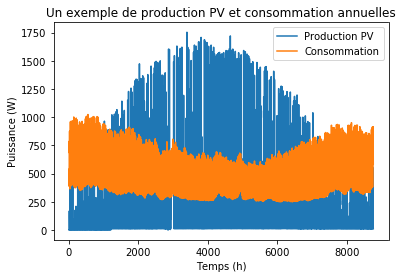

In [19]:
# plot
fig2, ax2 = plt.subplots()  
ax2.plot(yearly_pv_power_values, label='Production PV') 
ax2.plot(yearly_cons_values, label='Consommation') 
ax2.set_xlabel('Temps (h)')  
ax2.set_ylabel('Puissance (W)')  
ax2.set_title('Un exemple de production PV et consommation annuelles')
ax2.legend()  
print('Consommation annuelle d\'un foyer seul= {} kWh'.format(round(sum(yearly_cons_values)/1e3)))
print('Production annuelle des panneaux PV pour une inclinaison de {0}°, un azimut de {1}° et une surface de {2}m² = {3} kWh'.format(tilt, azimuth, surface, round(pv_energy)))

## Présentation de la modélisation énergétique

### Description générale

Un modèle énergétique est assemblé avec l'outil OMEGAlpes. Des unités d'énergie telles que des unités de consommation pour les panneaux photovoltaïques ou des unités de stockage pour la batterie sont créées, et reliées par des nœuds d'énergie qui assurent l'équilibre énergétique. Des objectifs sont ensuite ajoutés.
Un modèle du problème d'optimisation MILP est alors automatiquement généré et résolu par le package Python PuLP en utilisant le solveur CBC par défaut. D'autres solveurs peuvent être utilisés avec PuLP pour améliorer les performances de résolution.

### Schéma du cas d'étude

![cas d'étude autoconso PV OMEGAlpes](./figures/dwelling_pv_self_cons_omegalpes.png)

### Gestion du temps

Avec les solveurs open source tels que CBC, le solveur par défaut utilisé avec PuLP dans OMEGAlpes, il vaut mieux étudier des périodes inférieures à une saison en termes de durée (c'est-à-dire 3 mois). Une saison sera résolue en 5 minutes environ. Les performances seront améliorées avec des solveurs tels que Gurobi ou Cplex.
Compte tenu de ces limites, la partie suivante permet de choisir les dates auxquelles l'étude est réalisée en fonction des préférences des utilisateurs.

In [20]:
start_date = '26/08/2019 00:00'
end_date = '30/08/2019 23:00'  
consumption = yearly_consumption.loc[pd.to_datetime(start_date):pd.to_datetime(end_date)]
pv_power = yearly_pv_power.loc[pd.to_datetime(start_date):pd.to_datetime(end_date)]
time = TimeUnit(start=start_date, end = end_date, dt=1)

cons_values = consumption.values[:, 0]
pv_power_values = pv_power.values[:, 0]

You are studying the period from 2019-08-26 00:00:00 to 2019-08-30 23:00:00


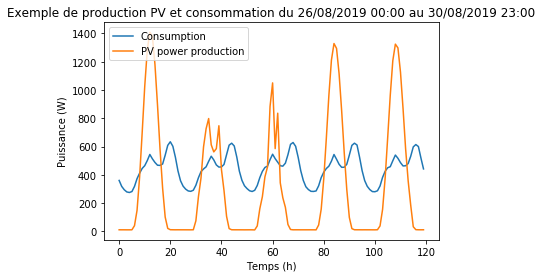

In [21]:
# plot
fig3, ax3 = plt.subplots()  
ax3.plot(cons_values, label='Consumption') 
ax3.plot(pv_power_values, label='PV power production') 
ax3.set_xlabel('Temps (h)')  
ax3.set_ylabel('Puissance (W)')  
ax3.set_title('Exemple de production PV et consommation du {0} au {1}'.format(start_date, end_date))
ax3.legend() 

### Paramètres du stockage

In [22]:
e_sto = 434
eff_sto_lead_acid = 0.75  # Charging and discharging storage efficiency for the lead acid battery
eff_sto_li_ion = 0.85  # Charging and discharging storage efficiency for the lithium-ion battery
dod_lead_acid = 0.5  # Depth of Discharge for the lead acid battery
dod_li_ion = 0.8  # Depth of Discharge for the lithium-ion battery
self_disch_lead_acid = 0.01  # A default self-discharge of 1% of stored energy losses per hour is considered

capa_bat = e_sto/dod_lead_acid
p_max_bat = capa_bat

In [23]:
# The maximal power values of the grid are chosen based on the maximal consumption and PV production values
max_grid_sizing = (max(max(pv_power_values), max(cons_values)))*2  

## Processus de modélisation énergétique

### Instanciation du modèle énergétique

In [24]:
# ENERGY UNITS
power_grid = ReversibleUnit(time=time, name="power_grid", pmax_cons=max_grid_sizing, 
                            pmax_prod=max_grid_sizing, 
                            energy_type_prod='Electrical', energy_type_cons=elec)

pv_pannels = FixedProductionUnit(time=time, name='PV_pannels', p=pv_power_values.tolist(), energy_type=elec)

dwelling_consumption = FixedConsumptionUnit(time=time, name='dwelling_consumption', p=cons_values.tolist(), 
                                            energy_type=elec)

battery = StorageUnit(time=time, name="battery", pc_max=p_max_bat, pd_max=p_max_bat, capacity=capa_bat,
                      e_0=0, soc_min=0, soc_max=dod_lead_acid, eff_c=eff_sto_lead_acid, 
                      eff_d=eff_sto_lead_acid, self_disch_t=self_disch_lead_acid, energy_type=elec)

elec_node = EnergyNode(time, name="elec_node", energy_type=elec)

Creating the power_grid_prod.
Creating the power_grid_cons.
Creating the power_grid.
Creating the PV_pannels.
Creating the dwelling_consumption.
Creating the battery.
Creating the elec_node.


Les contraintes sont ajoutées grâce aux paramétrages des objets OMEGAlpes, par exemple avec le l'état de charge maximal de la batterie.

### Ajout de la fonction objectif

Pour le choix des objectifs, nous pouvons simplement minimiser les imports du réseau, c'est-à-dire la `consommation_réseau`. Les exports peuvent également être minimisés pour maximiser la couverture de la consommation par l'énergie photovoltaïque locale. Ces deux objectifs sont déjà disponibles dans OMEGAlpes.   
Un objectif supplémentaire peut être ajouté afin de minimiser les pertes de stockage, pour que la charge des batteries ait lieu aux moments opportuns. Les pertes de la batterie comprennent l'autodécharge ainsi que les pertes de charge et de décharge :
$$ losses_{bat} = \sum_{time} dt*(self-disch*e_{sto}[t]+(P_{ch}[t]+P_{disch}[t])*(1-eff_{sto})) $$  
avec
- dt le pas de temps (e.g. avec des pas de temps 15 minutes, dt = 1/4)
- e_sto[t] l'énergie stockée à un instant t
- self_disch le taux de décharge de la batterie
- P_ch[t] la puissance de charge à l'instant t
- P_disch[t] la puissance de décharge à l'instant t
- eff_sto l'efficacité de charge et décharge

In [25]:
# OBJECTIVES
# Already available in OMEGAlpes
power_grid.production_unit.minimize_production()
# power_grid.consumption_unit.minimize_consumption()

# Objective developped specifically here
battery.mininimize_losses = Objective(exp='lpSum({3}*({0}_e[t]*{1}+ '
                                   '({0}_pc[t]+{0}_pd[t])*(1-{2}))'
                                   ' for t in time.I)'.format(
    battery.name, self_disch_lead_acid,  eff_sto_lead_acid, time.DT),
    name='min_losses', active=True, unit='Wh', parent=None)

# UNITS CONNECTION TO ENERGY NODE
elec_node.connect_units(pv_pannels, dwelling_consumption, battery, power_grid.production_unit, 
                        power_grid.consumption_unit)

### Résolution

In [26]:
# MODEL BUILT AND RUN
model = OptimisationModel(time, name="ORUCE")
model.add_nodes(elec_node)

model.solve_and_update()


--- Adding all variables to the model ---
Adding variable : PV_pannels_p
Adding variable : PV_pannels_e_tot
Adding variable : dwelling_consumption_p
Adding variable : dwelling_consumption_e_tot
Adding variable : battery_p
Adding variable : battery_e_tot
Adding variable : battery_u
Adding variable : battery_capacity
Adding variable : battery_e
Adding variable : battery_pc_max
Adding variable : battery_pd_max
Adding variable : battery_pc
Adding variable : battery_pd
Adding variable : battery_uc
Adding variable : battery_e_f
Adding variable : power_grid_prod_p
Adding variable : power_grid_prod_e_tot
Adding variable : power_grid_prod_u
Adding variable : power_grid_cons_p
Adding variable : power_grid_cons_e_tot
Adding variable : power_grid_cons_u

--- Adding all objectives to the model ---
Adding objective : battery_min_losses
Adding objective : power_grid_prod_min_production

--- Adding all constraints to the model ---
Adding constraint : elec_node_power_balance , exp = PV_pannels_p[t]-dw

## Gestion des résultats

### Affichage et tracé des résultats
Les indicateurs de résultats présentés ici sont la consommation du logement et la production PV en kWh, par rapport à l'énergie du réseau électrique. Nous calculons et affichons également le Load Cover Factor et le Supply Cover Factor, tels que définis par *Salom et al., 2014. "Analysis Of Load Match and Grid Interaction Indicators in NZEB with High-Resolution Data". IEA Solar Heating and Cooling Programme.* https://doi.org/10.18777/ieashc-task40-2014-0001.

Ils peuvent évidemment être discutés et améliorés en fonction des objectifs de l'étude.

In [27]:
# Print results
print('Consommation totale du foyer = {} kWh'.format(round(dwelling_consumption.e_tot.get_value()/1000,2)))
# Problème de porucentage car pertes batteries pour le PV ! 
print('{}% provenant du réseau'.format(round(power_grid.production_unit.e_tot.
                                                        get_value()/dwelling_consumption.e_tot.get_value()*100)))
print('Production PV totale  = {} kWh'.format(round(pv_pannels.e_tot.get_value()/1000,2)))
# batterie comprise ou consommée par le dwelling?
print('{}% consommée localement'.format(round((pv_pannels.e_tot.get_value()-power_grid.consumption_unit.e_tot.get_value())/pv_pannels.e_tot.get_value()*100)))
print('{}% injectée sur le réseau'.format(round(power_grid.consumption_unit.e_tot.get_value()/pv_pannels.e_tot.get_value()*100)))
print('Supply Cover Factor: {}'.format(round((pv_pannels.e_tot.get_value()-power_grid.consumption_unit.e_tot.get_value())/pv_pannels.e_tot.get_value(),2)))
print('Load Cover Factor: {}'.format(round((dwelling_consumption.e_tot.get_value()-power_grid.production_unit.e_tot.get_value())/dwelling_consumption.e_tot.get_value(),2)))

Consommation totale du foyer = 53.15 kWh
51% provenant du réseau
Production PV totale  = 39.84 kWh
69% consommée localement
31% injectée sur le réseau
Supply Cover Factor: 0.69
Load Cover Factor: 0.49



Preparing to plot the energetic flows through the node elec_node.
	Add power from PV_pannels.
	Add power from dwelling_consumption.
	Add power from battery.
	Add power from power_grid_prod.
	Add power from power_grid_cons.


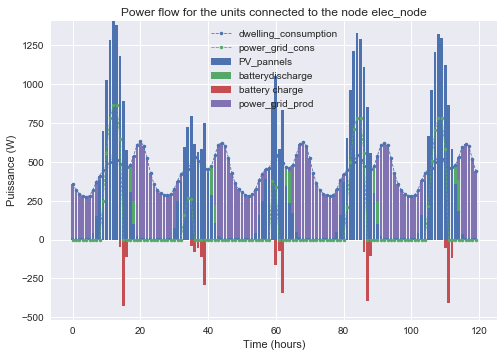

In [28]:
# Plot results
plt = plot_node_energetic_flows(elec_node)
plt.ylabel("Puissance (W)")  # changing label from default (kW) to W
plt.show()

### Sauvegarde des résultats
Enfin, les flux d'énergie peuvent être sauvegardés sous forme de fichiers csv.

In [29]:
save_energy_flows(elec_node, sep=';', file_name='results/ORUCE_PV_results')

### Interpretation des résultats

Dans ce cas, les résultats concernant la gestion des batteries sont assez triviaux mais ils permettent de voir les flux d'énergie pour la période étudiée. Le modèle OMEGAlpes est accessible pour des études plus approfondies sur ce système énergétique.

## Conclusion

### Discussion and perspectives

D'autres approches pourraient être envisagées dans cette étude. Une partie de l'appel de puissance pourrait être gérée pour refléter une éventuelle adaptation de la consommation à la production locale. Les travaux futurs pourraient également inclure une gestion des batteries en fonction des émissions dynamiques de GES du réseau électrique en CO2. Il serait également intéressant de réaliser l'étude à l'échelle du quartier afin de qualifier et quantifier les conséquences sur les réseaux d'énergie, d'évaluer la pertinence du dimensionnement avec les indicateurs présentés ici.
Une perspective envisagée est d'étendre cette étude de cas à l'échelle des opérations d'autoconsommation collective afin d'intégrer les enjeux de la communauté énergétique. Un point d'intérêt particulier est l'autonomisation des communautés énergétiques locales, avec l'émergence d'une " économie du partage " dans laquelle les ressources ainsi que les biens communs numériques et matériels sont identifiés et utilisés de manière mutualisée (*Kostakis et al. 2015* - DOI : https://doi.org/10.1016/j.jclepro.2016.09.077). 

## Fiche descriptive

| Nom                          | Autoconsommation photovoltaïque d'un foyer                                                                                           |
| ---------------------------- | ------------------------------------------------------------------------------------------------------------ |
| Description                  | Cas d'étude d'autoconsommation PV développé comme un scénario type pour l'ouverture du processus de modélisation avec la méthode ORUCE |
| Objectif                     | L'objectif sur ce cas d'étude est la gestion optimale des flux de puissance est appliquée à la conception du système énergétique obtenu.                                                               |
| Laboratoire                  | G2Elab                                                      |
| Contact                      | Sacha Hodencq - sacha.hodencq@g2elab.grenoble-inp.fr                                                                 |
| Lien                         | *à venir*                                                        |
| Documents & données associés | S. Hodencq, B. Delinchant, and F. Wurtz, ‘Open and Reproducible Use Cases for Energy (ORUCE) methodology in systems design and operation: a dwelling photovoltaic self-consumption example’, Bruges, Belgium, Sep. 2021. Accessed: Sep. 16, 2021. Available: https://hal.archives-ouvertes.fr/hal-03341883 . Données : ensoleillement Grenoble, données de consommation RES1 Enedis                                              |
| Outils associés              | [OMEGAlpes](https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes/omegalpes)                                                                  |
| Licence                      | Apache 2.0                                                            |

| Paramètre                              | Paramétrage proposé                                                                                                                                 | Description (plus exhaustif, langage de vulgarisation nécessaire)                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| -------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Acteurs                                | G2Elab (laboratoire de recherche), secondaires : Enedis pour la fourniture de données (gestionnaire de réseau de distribution)                                                                                         | Le cas d'étude est fictif, aussi il y a peu d'interaction entre acteurs.                                                                                                                                                                                              |
| Terrain                                | Grenoble, France                                                                                                                          |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| Enjeux                                 | Autoconsommation individuelle                                                                              |                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| Secteurs                               | Electricité                                                                                                        |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| Analyses                               | Énergétique                                                                                      | solaire PV, stockage batterie, réseau infini, consommation résidentielle                                                                                                                                                                                                                                                                                                                  |
| Hypothèses                             | Consommation et émissions moyennes estimées                                                                                                           | La consommation moyenne d'un logement français est basée sur les profils [RES1](https://www.enedis.fr/coefficients-des-profils) Enedis, c'est-à-dire les profils de consommation des logements raccordés en basse tension avec une puissance nominale inférieure à 6 kVA. On considère une consommation annuelle de 4453 kWh par foyer, en appliquant une consommation annuelle de 4586 kWh aux profils RES1. Cette consommation est calculée à partir du nombre de foyers raccordés au réseau selon un [rapport de la CRE](https://www.cre.fr/Documents/Publications/Rapports-thematiques/Etat-des-lieux-des-marches-de-detail-de-l-electricite-et-du-gaz-naturel-en-2017), page 19 (32,4 millions de consommateurs résidentiels en 2017), et la [consommation d'électricité finale du secteur résidentiel](https://opendata.reseaux-energies.fr/explore/dataset/consommation-annuelle-nette-typologie/table/?disjunctive.segment&sort=annee) de 148,6 TWh en 2019. On considère les émissions de CO2 euroépnnes (source: [EEA](https://www.eea.europa.eu/data-and-maps/daviz/co2-emission-intensity-5#tab-googlechartid_chart_11_filters=%7B%22rowFilters%22%3A%7B%7D%3B%22columnFilters%22%3A%7B%22pre_config_ugeo%22%3A%5B%22European%20Union%20(current%20composition%22%5D%7D%7D).                                                                                                                                                                                                                                                                                                                                                             |
| Nature du cas d'étude                  | Cas applicatif de la méthode ORUCE pour une thèse|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| Comment le cas d'étude est établi ?    | Optimisation MILP                                            |                                                                                                                                                                                                                                        |
| Pourquoi le cas d'étude est-il établi? | Aide à la compréhension, Étude de solutions                                  | Aide à la compréhension de la méthode ORUCE et de l'autoconsommation, étude d'un dimensionnement donné pour le système d'autoconsommation.                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
| Finesse modèle / représentation        | Modèles macroscopiques de bilans de puissances                                                                                                               |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| Représentativité / Transposabilité     | Cas d'étude type                                                                                                                            | Données de localités fixes, mais cas d'étude pour un cas d'autoconsommation. Le modèle énergétique ainsi que la prise en compte de LCF et SCF sont proches de travaux de recherche répandus (voir Salom et al. - DOI: 10.18777/ieashc-task40-2014-0001).                                                                                                                                                                                                                                                                                                                                                                                                                     |
| Phase d’utilisation                    | pré-dimensionnement                                                |  |
| Échelle temporelle                     | Horizon : mois à année / Pas de temps : heure                                    |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| Échelle spatiale                       |bâtiment                             |    
| Résultats            | Il ne faut pas déduire de conclusions générales du cas d'étude simplifié présenté ici, car beaucoup d'hypothèses sont faites et des valeurs incertaines sont utilisées. L'objectif de l'étude est de souligner l'importance du processus ouvert de modélisation énergétique. L'étude fournit des modèles simples pour adapter l'étude de cas à différentes situations, par exemple en faisant varier les technologies des batteries ou des panneaux photovoltaïques, ou en sélectionnant les données d'entrée en fonction des nouvelles caractéristiques de l'étude et en tenant compte des incertitudes. Elle permet également de comparer différents modèles énergétiques, méthodes de réduction de la période d'étude ou du modèle, et techniques d'optimisation. ||
| Analyse incertitudes |Aucune analyse d'incertitude n'a été réalisée dans cette étude. ||